Karina Chiñas Fuenes | 24/02/2023 | Universiteit Gent

In [1]:
%load_ext autoreload
%autoreload 2

This notebook is based on the document:

* _Feature Selection for Clustering_, [Manoranjan Dash and Huan Liu](https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf), 2000.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

import FeatureSelectTK as fs

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

pd.set_option('display.max_columns', None)
path = "../../data/"

In [3]:
# Reading data and preparing it

DB5 = pd.read_csv(path+"DB5.csv") #From DB5 dataset | log data
subset_ids = pd.read_csv(path+"R_ids_alpha_0.6556.csv")
data_complete = (DB5[DB5.id.isin(subset_ids.id.values)]).reset_index(drop=True)

not_useful_cols = ['ind', 'id', 'PHASE', 'DATE', 'SHOT', 'TOK','TIME']
all_cols = pd.Series(data_complete.columns)
data = data_complete[ all_cols[~all_cols.isin(not_useful_cols)].values ]
data = data.dropna(axis='columns')

In [4]:
DB5

,ind,id,PHASE,TOK,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,TAUTH,DATE,SHOT,TIME,Q95,ZEFF,AMIN,VOL,POHM,PNBI,DWDIA,DWMHD,PICRH,PECRH,PL,PFLOSS,TAV,LCOULOMB,QCYL5,TAUBOHM,RHOSTAR,BETASTAR,NUSTAR,OMEGACYCL
0,12405,HDULEH,HGELM,ASDEX,0.2959,2.205,3.789,1.8700,1.6940,0.9748,0.242090,1.5,0.05100,19820622,5980,1.205,4.563,NaN,0.4101,5.4820,68660.0,2599000.0,212000.0,212000.0,0.0,0.0,2456000.0,585700.0,1086.986716,15.406717,3.606992,0.074970,0.006430,0.601125,0.223030,1.470000
1,12406,NAC6N1,HGELM,ASDEX,0.2952,2.205,3.734,2.0240,1.6840,0.9724,0.244240,1.5,0.04902,19820622,5980,1.224,4.671,NaN,0.4113,5.4680,22960.0,2598000.0,0.0,0.0,0.0,0.0,2621000.0,596700.0,1150.578521,15.470883,3.647604,0.072059,0.006596,0.627056,0.195418,1.470000
2,12411,U2T1C7,HSELM,ASDEX,0.2971,2.205,3.410,1.1320,1.6930,0.9895,0.238807,1.5,0.06375,19820622,5982,1.188,4.275,NaN,0.4043,5.4050,0.0,2590000.0,815400.0,942200.0,0.0,0.0,1690000.0,558000.0,927.006370,15.300207,3.544311,0.093713,0.006023,0.461374,0.274718,1.470000
3,12412,422XQB,HGELM,ASDEX,0.2959,2.205,3.775,1.3760,1.6930,0.9744,0.242351,1.5,0.06991,19820622,5982,1.216,4.574,NaN,0.4103,5.4820,31630.0,2599000.0,683900.0,662500.0,0.0,0.0,1961000.0,584900.0,1100.512996,15.420935,3.611224,0.102768,0.006467,0.606357,0.216753,1.470000
4,12413,WZ9FED,HGELM,ASDEX,0.2942,2.204,3.847,2.0330,1.6850,0.9691,0.244926,1.5,0.05151,19820622,5982,1.244,4.758,NaN,0.4127,5.4900,37030.0,2600000.0,0.0,0.0,0.0,0.0,2637000.0,604000.0,1173.621999,15.475806,3.668909,0.075685,0.006642,0.659569,0.193993,1.469333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,24961,NGC85H,HSELM,TDEV,-0.2198,1.963,4.919,0.6145,0.8274,1.1080,0.259971,2.0,0.01666,19980407,33119,0.800,3.203,NaN,0.2151,0.8371,102100.0,0.0,-1906.0,-1906.0,0.0,510500.0,614500.0,0.0,588.737748,14.663031,2.793295,0.016352,0.011702,0.533324,0.319289,0.981500
6246,24963,ID1IP4,HSELM,TDEV,-0.2199,1.952,5.109,0.6358,0.8356,1.1010,0.258018,2.0,0.01710,19980408,33155,0.800,3.143,NaN,0.2156,0.8439,125200.0,0.0,401.3,401.3,0.0,511000.0,635800.0,0.0,596.868618,14.657798,2.757587,0.016690,0.011822,0.567921,0.325224,0.976000
6247,24964,K19A5H,HSELM,TDEV,-0.2198,1.951,5.337,0.3762,0.8350,1.1030,0.257844,2.0,0.02543,19980408,33171,0.800,3.131,NaN,0.2153,0.8426,167500.0,0.0,-1447.0,-1447.0,0.0,207200.0,376200.0,0.0,503.655066,14.466163,2.757718,0.024807,0.010880,0.501128,0.471050,0.975500
6248,26411,D26CA1,HSELM,TFTR,0.9794,4.795,3.500,5.1120,2.4540,0.9997,0.327343,2.0,0.17310,19900124,45980,4.600,8.050,NaN,0.8033,31.2500,-732600.0,10310000.0,162800.0,162800.0,0.0,0.0,9410000.0,4297000.0,1916.017316,16.013226,6.010681,0.415007,0.002314,0.206978,0.105809,2.397500


In [5]:
# Standard Scaler
X = StandardScaler().fit_transform(data)
data = pd.DataFrame(X, columns=data.columns)

N,M = data.shape

In [12]:
data

,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,TAUTH,Q95,AMIN,VOL,POHM,PNBI,PICRH,PECRH,PL,PFLOSS,TAV,LCOULOMB,QCYL5,TAUBOHM,RHOSTAR,BETASTAR,NUSTAR,OMEGACYCL
0,0.765997,-0.527184,0.296101,-0.800000,-0.589310,0.115482,-0.438725,0.072027,-0.556718,-0.320391,-0.900073,-0.799528,0.123092,-0.620138,-0.379139,-0.250986,-0.699653,1.651783,-0.557330,-0.517250,0.088336,-0.415992,-0.249331,-0.391663,0.059014,0.459269
1,0.627971,-0.103853,0.427405,-0.418350,-0.590747,0.301506,-0.457199,-1.510995,-0.918659,-0.428837,-0.916265,-0.800519,0.234006,-0.066326,-0.379139,-0.250986,-0.184333,3.430933,-0.908808,-1.049850,-0.106103,-0.732254,-0.270589,-0.288824,0.803827,0.544981
2,0.903268,-0.864401,1.111807,-1.062385,-0.582127,0.363514,-0.515480,0.072027,-0.229312,-0.513709,-0.953710,-0.810099,1.713752,-1.167876,-0.379139,-0.250986,-1.079490,0.098397,-0.829112,-1.117911,-0.120046,0.076628,-0.515709,-0.466233,0.994830,1.172519
3,0.903268,-0.864401,1.221226,-1.069541,-0.585000,0.260168,-0.500971,0.072027,-0.243543,-0.516066,-0.945108,-0.810429,2.131128,-1.177119,-0.379139,-0.250986,-1.081909,0.153321,-0.884482,-1.230363,-0.111040,0.061422,-0.541568,-0.470546,1.242381,1.172519
4,0.629344,-0.175493,-0.174403,-1.327154,-0.599366,0.342845,-0.448350,0.072027,-0.220773,-0.276384,-0.918289,-0.801510,-0.149071,-1.389718,-0.379139,-0.250986,-1.406101,-0.762873,-0.744559,-0.587053,0.132185,-0.320849,-0.059986,-0.366736,0.148291,-0.284593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,0.228518,1.481359,-0.545018,-1.661098,-2.559456,-0.824971,4.454396,-0.877786,-1.386629,0.998257,-2.290078,-1.213965,0.122201,-1.712180,-0.379139,-0.250986,-1.685294,0.098060,-1.631830,-2.682526,-1.819638,-1.181857,9.237902,3.307478,-0.588163,-2.897561
1481,0.214029,1.486135,-0.437363,-1.671331,-2.569799,-1.083337,4.546102,-0.877786,-1.388318,1.478408,-2.305258,-1.214916,-0.084037,-1.715085,-0.379139,-0.250986,-1.689407,0.184322,-1.667906,-2.942189,-1.603331,-1.181988,8.488676,2.888661,-0.471194,-2.885677
1482,0.229960,1.484471,-0.612081,-1.685619,-2.564053,-0.742294,4.408230,-0.877786,-1.385490,0.759360,-2.308800,-1.214517,-0.186487,-1.709275,-0.379139,-0.250986,-1.706584,0.146919,-1.633598,-2.657891,-1.976387,-1.181684,9.215466,3.004839,-0.613323,-2.889818
1483,0.229823,1.490332,-0.452187,-1.760136,-2.576838,-0.731959,4.473478,-0.877786,-1.374134,0.730284,-2.334100,-1.215518,0.144028,-1.935607,-0.379139,-0.250986,-1.888809,-1.337053,-1.690483,-3.079501,-1.973856,-1.180258,8.120351,2.430860,-0.461595,-2.875233


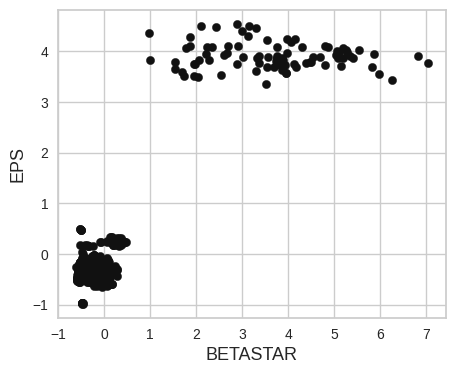

In [6]:
plt.figure(figsize=(5,4))
plt.scatter(data.BETASTAR, data.EPS, s=35, c="k")
plt.ylabel("EPS", fontsize=13)
plt.xlabel("BETASTAR", fontsize=13);

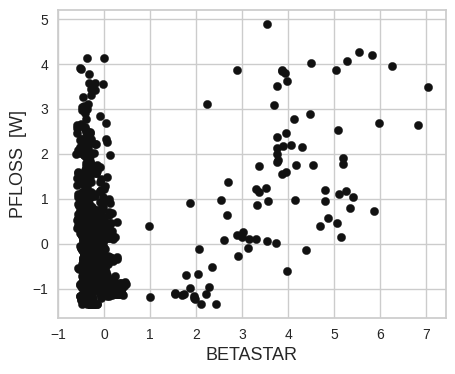

In [7]:
plt.figure(figsize=(5,4))
plt.scatter(data.BETASTAR, data.PFLOSS, s=35, c="k")
plt.xlabel("BETASTAR", fontsize=13)
plt.ylabel("PFLOSS  [W]", fontsize=13);

## ENTROPY IN DATASET
#### Using the concept of entropy to rank the importance of features.

1. Computing the distance between two points with Euclidean distance:

$$
    D^k_{ij} = \left( \frac{ x_{ik} - x_{jk} }{ max(F_k) - min(F_k) } \right)^2 
$$

$$
    D_{ij} = \left[ \sum^M_{k=1} \: D^k_{ij}\right]^{1/2}
$$

Where $F_k$ is the $k$-th column representing the $k$-th feature. With $k=1,\dots,M$ The $x_{ik}$ is the $i$-th point of the $k$-th feature; the same for $j$. With $i$,$j=1\ldots,N$. And $N$ being the total points of observations.

2. Computing the similarity between two points, as:

$$
    S_{ij} = e^{-\alpha \cdot D_{ij}}
$$

Where $\alpha$ is a parameter. Here $\alpha = 0.5$.

3. The entropy of the dataset is thus:

$$
    E = -\sum^N_{i=1}\sum^N_{j=1} E_{ij}= -\sum^N_{i=1}\sum^N_{j=1}\left[ S_{ij}\cdot\text{Log}\left(S_{ij}\right) +  \left(1-S_{ij}\right)\cdot\text{Log}\left(1-S_{ij}\right) \right]
$$

In the expression above, $N$ corresponds to the total number of observations in dataset (rows). 

The ranking is done in an interative process: eliminate a column at a time and assess the disorder that the removal has caused by calculating the corresponding entropy. Let us sat that $E_{^-F_i} > E_{^-F_j}$ is the statement that the removal of feature $i$ of the dataset caused more disorder than the removal of feature $j$. One can then construct an array $\vec{E_-} = \{E_{F_k}\}$, for $k=1,\ldots,M$. Thus, the most important feature will be  max$(\vec{E_-})$.

In [8]:
# ranked features of dataframe based on their entropy of removal
features_ranked_entropy = fs.get_ranked_features(data)
feature_dic = dict( zip( list(range(M)), data.columns ) )
ordered_features = list(features_ranked_entropy.index.map(feature_dic))

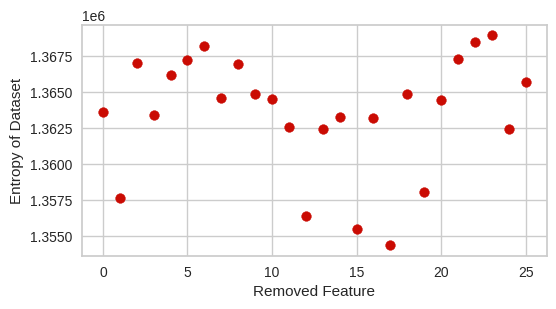

In [9]:
plt.figure(figsize=(6,3))
plt.scatter(features_ranked_entropy.index, features_ranked_entropy.values, c="r")
plt.xlabel("Removed Feature")
plt.ylabel("Entropy of Dataset");

In [10]:
print(ordered_features,)

['BETASTAR', 'RHOSTAR', 'EPS', 'TAUBOHM', 'KAREA', 'NEL', 'TAUTH', 'RGEO', 'OMEGACYCL', 'Q95', 'TAV', 'MEFF', 'AMIN', 'QCYL5', 'IP', 'PLTH', 'PICRH', 'PL', 'VOL', 'NUSTAR', 'PNBI', 'LCOULOMB', 'BT', 'POHM', 'PECRH', 'PFLOSS']


## CHOOSING FEATURES FOR CLUSTERING

For this section, I am using K-means with K = 4. If analyses seem favorable, I will extend the study on the variation of K. 

#### Scattering Criteria 

This criteria makes use of multiple discriminant analysis to compute the scatter matrices. The scatter matrix for the $j$-th cluster is 

$$
    P_j = \sum_{x_i\in\chi_j}\left(X_i - m_j\right)\left(X_i - m_j\right)^T
$$

which is a square matrix of dimensions equal to the total number of observations belonging to the $j$-th clusters. The within-cluster scatter matrix is

$$
    P_w = \sum^C_{j=1} P_j
$$

Where $C$ is the total number of clusters. The between-cluster scatter matrix is

$$
    P_B = \sum^C_{j=1} \left( m_j - m \right)\left( m_j - m \right)^T
$$

With $m$ being the total mean vector. Then, one computes

$$
    tr(P^{-1}_wP_B) 
$$

The higher the trace, the higher the quality of the clustering. 

In [11]:
zzzzzzzz

NameError: name 'zzzzzzzz' is not defined

In [ ]:
n_clusters = 4
Y_lbls = [0]*M

for k,feature in enumerate(ordered_features):
    X = data[ ordered_features[:k+1] ].to_numpy()
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    Y_lbls[k] = kmeans.predict(X)

In [ ]:
Pw = [0]*n_clusters; dim_per_cluster = [0]*n_clusters
for num_cluster in range(n_clusters):
    for i in range(M):
        x = data[ ordered_features[:i+1] ].to_numpy()
        y = Y_lbls[i]
        df  = pd.DataFrame(x, columns=ordered_features[:i+1]); df["labels"] = y
        df_ = df[df.labels.isin([num_cluster])][ordered_features[:i+1]]
        X_m = (df_ - df_.mean()).to_numpy()
        Pj_ = np.matmul(X_m, X_m.T )
    Pw[num_cluster] = Pj_; 
    dim_per_cluster[num_cluster] = len(Pj_[0])

In [ ]:
max_dim = max(dim_per_cluster)
# How to construct P_w when my clusters have different size??????